# Second Harmonic Generation


## SHG without Dispersion: Perfect Phase Matching

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import meep as mp
from meep.materials import LiNbO3
from copy import copy

c = 2.998e8  # speed of light
a = 1e-6  # charasteristic length scale (m)

# Nd:YAG laser wavelength 1064 nm converted to Meep frequency units
f_pump = a/1064e-9

# permittivity at source frequency. .epsilon() returns the permittivity
# tensor, so we index an element that is on the diagonal
eps = LiNbO3.epsilon(f_pump)[0,0]
n0 = np.sqrt(eps)  # refractive index

In [14]:
def chi2_propagation(chi2, f_pump, amplitude, resolution, flux_spectrum=True, dispersion=False,
                     quasi_phase_matching=False, coherence_length=0):

    """Propagate pulse in a second order nonlinear material and measure
    output spectrum or SHG power at different propagation distances.

    :param chi2: float, second order nonlinear susceptibility
    :param f_pump: float, pump frequency
    :param amplitude: float, pump current amplitude J
    :param resolution: int, resolution of simulation
    :param flux_spectrum: bool, determines whether output spectrum (True) or
    SHG power at different propagation distances (False) is returned
    :param dispersion: bool, determines whether dispersion is used
    :param quasi_phase_matching: bool, determines whether quasi-phase matching
    is used
    :param coherence_length: float, if quasi-phase matching is used, determines
    the length after which sign of chi2 is swithced
    :return: if flux_spectrum==True, returns tuple the (spectral powers,
    corresponding frequencies), otherwise returns the tuple (SHG powers,
    corresponding propagation distances, initial pump power)
    """

    # perfectly matched layers
    pml_size = 2.0
    pml_layers = [mp.PML(pml_size)]

    # define simulation cell (15 µm propagation distance)
    cell_len = 15 + 2*pml_size
    cell = mp.Vector3(0, 0, cell_len)

    # define pump source
    source_loc = mp.Vector3(0, 0, -0.5*cell_len + pml_size)
    f_width = f_pump/20.0
    sources = [
        mp.Source(
            mp.GaussianSource(f_pump, fwidth=f_width),
            component=mp.Ex,
            center=source_loc,
            amplitude=amplitude,
        )
    ]

    geometry = []
    if quasi_phase_matching and dispersion:
        default_material = LiNbO3

        # create geometry where sign of chi2 is swithced every
        # coherence length

        z = source_loc[2]
        sign = 1
        while True:
            if z >= cell_len/2:
                break

            z_start = z
            z_end = np.min([z+coherence_length, cell_len/2])
            # previously defined geometry is affected without copy
            material = copy(LiNbO3)
            # add nonlinearity with switched sign
            material.E_chi2_diag = mp.Vector3(sign*chi2, sign*chi2, sign*chi2)
            block = mp.Block(size=mp.Vector3(0, 0, z_end-z_start),
                             center=mp.Vector3(0, 0, (z_start+z_end)/2),
                             material=material)
            geometry.append(block)

            z += coherence_length
            sign *= -1
            
    elif dispersion:
        # dispersion is automatically included with the imported material
        default_material = LiNbO3
        # add nonlinearity
        default_material.E_chi2_diag = mp.Vector3(chi2, chi2, chi2)

    elif not dispersion:
        # note the constant epsilon (no dispersion) and
        # second order nonlinear susceptibility chi2
        default_material = mp.Medium(epsilon=LiNbO3.epsilon(f_pump)[0,0], chi2=chi2)
    
    else:
        print('bad input')
        return

    # define simulation object
    sim = mp.Simulation(
        cell_size=cell,
        sources=sources,
        boundary_layers=pml_layers,
        default_material=default_material,
        geometry=geometry,
        resolution=resolution,
        dimensions=1,
    )

    end_loc = mp.Vector3(0, 0, 0.5*cell_len - pml_size)
    if flux_spectrum:
        # define flux object for measuring the spectrum after propagation
        f_min = f_pump/2
        f_max = f_pump*3.5
        n_freq = 600
        trans = sim.add_flux(0.5*(f_min + f_max), f_max-f_min, n_freq, mp.FluxRegion(end_loc))
    else:
        # monitor power at SHG frequency in different locations along
        # propagation length
        n_monitors = 100
        monitor_locs_z = np.linspace(source_loc[2], end_loc[2], n_monitors)
        propagation_shg_fluxes = []
        for z in monitor_locs_z:
            # measure flux at twice the pump frequency             
            shg_flux = sim.add_flux(2*f_pump, 0, 1, mp.FluxRegion(mp.Vector3(0, 0, z)))
            propagation_shg_fluxes.append(shg_flux)
        
        # measure initial pump power for reference. Note that flux object
        # cannot be exactly on top of source because equal power is emitted
        # to the left and right of the source.
        pump_flux = sim.add_flux(f_pump, 0, 1, mp.FluxRegion(source_loc+mp.Vector3(0, 0, 0.1)))
    
    # run for sufficiently long such that the pulse has fully passed
    #  through the end of the material
    sim.run(until=250)

    if flux_spectrum:
        # retrieve spectral powers and corresponding frequencies
        trans_flux = mp.get_fluxes(trans)
        freqs = mp.get_flux_freqs(trans)

        return np.array(trans_flux), np.array(freqs)

    else:
        # retrieve SHG power along propagation
        propagation_shg_powers = []
        for flux in propagation_shg_fluxes:
            propagation_shg_powers.append(mp.get_fluxes(flux))
        
        # retrieve pump power
        pump_power = mp.get_fluxes(pump_flux)
        
        return ( np.array(propagation_shg_powers).flatten(),
                 # change coordinates such that source is at z=0
                 monitor_locs_z-source_loc[2],
                 pump_power )

In [15]:
source_amplitude = 1  # source current amplitude J
Z = np.sqrt(1/eps)  # impedance of medium
E = Z*source_amplitude/2  # electric field amplitude
E /= np.sqrt(2)  # Gaussian source

chi2_E_prod = 0.003  # dimensionless product
chi2 = chi2_E_prod / E  # in Meep units

In [16]:
res = 256
reference_trans_flux, freqs = chi2_propagation(chi2=0, f_pump=f_pump, amplitude=source_amplitude, resolution=res)
trans_flux, freqs = chi2_propagation(chi2=chi2, f_pump=f_pump, amplitude=source_amplitude, resolution=res)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 256
time for set_epsilon = 0.00090003 s
-----------
run 0 finished at t = 250.0 (128000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000233889 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 256
time for set_epsilon = 0.000827074 s
-----------
run 0 finished at t = 250.0 (128000 timesteps)


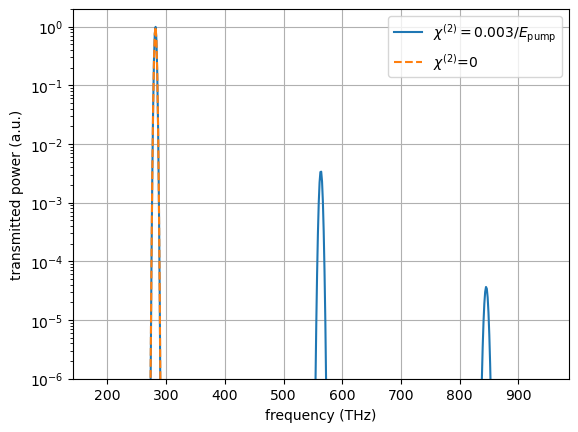

In [17]:
fig, ax = plt.subplots()

# convert frequencies from Meep units to SI units
freqs_SI = freqs * c/a

norm = np.max(reference_trans_flux)
ax.semilogy(freqs_SI*1e-12, trans_flux/norm, label=fr"$\chi^{{(2)}}={chi2_E_prod}/E_{{\text{{pump}}}}$")
ax.semilogy(freqs_SI*1e-12, reference_trans_flux/norm, linestyle="--", label=rf"$\chi^{{(2)}}$={0}")
ax.set_xlabel("frequency (THz)")
ax.set_ylabel("transmitted power (a.u.)")
ax.set_xlim([freqs_SI[0]*1e-12, freqs_SI[-1]*1e-12])
ax.set_ylim([1e-6, 2])
ax.legend()
ax.grid(True)
fig.savefig('shg_spectrum.png', dpi=300, bbox_inches='tight')

In [18]:
# perform convergence analysis by doubling resolution repeatedly
resolutions = 32 * 2**np.arange(4)
shg_powers = []

for res in resolutions:
    # measure SHG power during propagation and initial pump power
    shg_power, z, pump_power = chi2_propagation(chi2=chi2, f_pump=f_pump, amplitude=source_amplitude,
                                                resolution=int(res), flux_spectrum=False)
    shg_powers.append(shg_power)

shg_powers = np.array(shg_powers)

-----------
Initializing structure...
time for choose_chunkdivision = 4.29153e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 32
time for set_epsilon = 0.000123024 s
-----------
run 0 finished at t = 250.0 (16000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.60555e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 64
time for set_epsilon = 0.000241995 s
-----------
run 0 finished at t = 250.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000144958 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 128
time for set_epsilon = 0.000432014 s
-----------
run 0 finished at t = 250.0 (64000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 256
time for set_epsilon = 0.000831842 s
-----------
Meep progress: 2

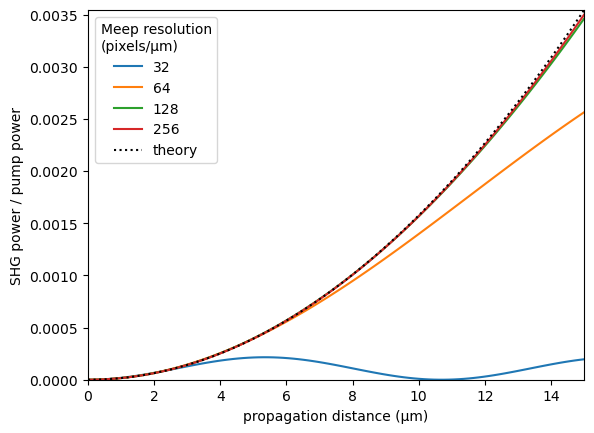

In [19]:
fig, ax = plt.subplots()

# plot the power ratio simulated in Meep
ax.plot(z, shg_powers.T/pump_power, label=resolutions)

# calculate power ratio predictedy by theory
z_theory = np.linspace(0, z[-1]*a, 200)
f_pump_SI = f_pump * c/a  # convert f from Meep units to SI units
omega_pump_SI = 2*np.pi*f_pump_SI
power_ratio_theory = omega_pump_SI**2 / (4*n0**2*c**2) * (chi2_E_prod)**2 * z_theory**2

# plot power ratio predicted by theory
ax.plot(z_theory/a, power_ratio_theory, "k:", label="theory")

ax.set_xlabel("propagation distance (µm)")
ax.set_ylabel("SHG power / pump power")
ax.set_xlim([0, z[-1]])
ax.set_ylim([0, power_ratio_theory[-1]])
leg = ax.legend()
leg.set_title("Meep resolution\n(pixels/µm)")

fig.savefig('shg_no_dispersion.png', dpi=300, bbox_inches='tight')

## SHG with Dispersion: Phase Matching Problem



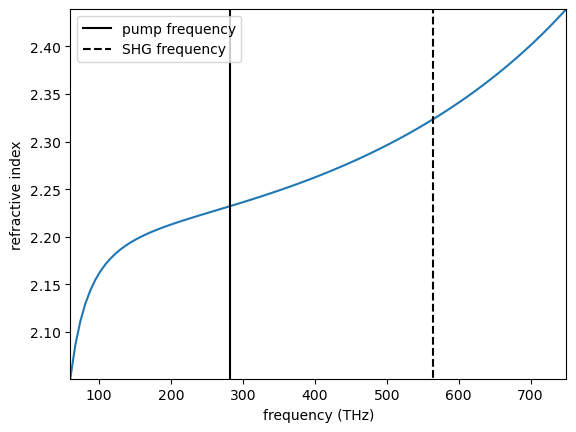

In [20]:
freqs = np.linspace(0.2, 2.5, 100)  # in Meep units
freqs_SI = freqs * c/a  # convert to SI units

# .epsilon() returns the permittivity tensor at given frequency,
# so we index an element that is on the diagonal
epsilon = np.array([LiNbO3.epsilon(f)[0][0] for f in freqs])
n = np.sqrt(epsilon)

# plot dispersion relation
fig, ax = plt.subplots()
ax.plot(freqs_SI*1e-12, n)

# draw vertical lines at pump and SHG frequencies
ax.plot([f_pump_SI*1e-12, f_pump_SI*1e-12], [0, 10], 'k-', label='pump frequency')
ax.plot([2*f_pump_SI*1e-12, 2*f_pump_SI*1e-12], [0, 10], 'k--', label='SHG frequency')

ax.set_xlabel('frequency (THz)')
ax.set_ylabel('refractive index')
ax.set_xlim([freqs_SI[0]*1e-12, freqs_SI[-1]*1e-12])
ax.set_ylim([n.min(), n.max()])
ax.legend(loc='upper left')

fig.savefig('shg_dispersion_relation.png', dpi=300, bbox_inches='tight')

In [21]:
# perform convergence analysis by doubling resolution repeatedly
resolutions_disp = 32 * 2**np.arange(6)
shg_powers_disp = []

for res in resolutions_disp:
    # measure SHG power during propagation and initial pump power
    shg_power_disp, z, pump_power_disp = chi2_propagation(chi2=chi2, f_pump=f_pump, amplitude=source_amplitude,
                                             resolution=int(res), flux_spectrum=False, dispersion=True)
    shg_powers_disp.append(shg_power_disp)

shg_powers_disp = np.array(shg_powers_disp)

-----------
Initializing structure...
time for choose_chunkdivision = 4.00543e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 32
time for set_epsilon = 0.000135899 s
lorentzian susceptibility: frequency=0.0490243, gamma=0
lorentzian susceptibility: frequency=3.87492, gamma=0
lorentzian susceptibility: frequency=6.98942, gamma=0
lorentzian susceptibility: frequency=0.0459025, gamma=0
lorentzian susceptibility: frequency=4.11206, gamma=0
lorentzian susceptibility: frequency=7.52923, gamma=0
-----------
run 0 finished at t = 250.0 (16000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.20024e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 64
time for set_epsilon = 0.0002141 s
lorentzian susceptibility: frequency=0.0490243, gamma=0
lorentzian susceptibility: frequency=3.87492, gamma=0
lorentzian susceptibility: frequency=6.98942, gamma=0
lorentzian susceptibility: frequency=0.0459025, gamma=

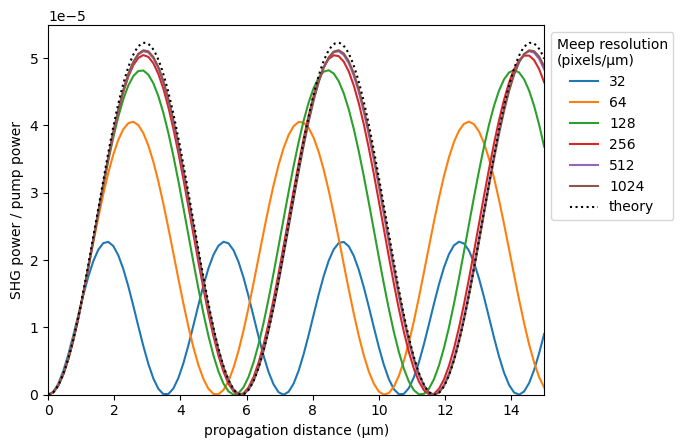

In [22]:
fig, ax = plt.subplots()

# plot the power ratio simulated in Meep
ax.plot(z, shg_powers_disp.T/pump_power_disp, label=resolutions_disp)

n1 = n0
n2 = np.sqrt(LiNbO3.epsilon(2*f_pump)[0,0])
delta_k_SI = 2*omega_pump_SI/c * (n1 - n2)
power_ratio_theory_disp = omega_pump_SI**2 / (n1*n2 * c**2 * delta_k_SI**2) * (chi2_E_prod)**2 * np.sin(delta_k_SI*z_theory/2)**2

# plot power ratio predicted by theory
ax.plot(z_theory/a, power_ratio_theory_disp, "k:", label="theory")

ax.set_xlabel("propagation distance (µm)")
ax.set_ylabel("SHG power / pump power")
ax.set_xlim([0, z[-1]])
ax.set_ylim([0, 1.05*power_ratio_theory_disp.max()])
leg = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
leg.set_title("Meep resolution\n(pixels/µm)")

fig.savefig('shg_with_dispersion.png', dpi=300, bbox_inches='tight')

## Quasi-Phase Matching

In [23]:
delta_k = delta_k_SI*a
coherence_length = np.abs(np.pi/delta_k)
shg_power_quasi, z, pump_power_quasi = chi2_propagation(chi2=chi2, f_pump=f_pump, amplitude=source_amplitude,
                                                        resolution=512, flux_spectrum=False, dispersion=True,
                                                        quasi_phase_matching=True, coherence_length=coherence_length)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000516891 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 19 with resolution 512
     block, center = (0,0,-6.03984)
          size (0,0,2.92032)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.11953)
          size (0,0,2.92032)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.199211)
          size (0,0,2.92032)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,2.72111)
          size (0,0,2.92032)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,5.64142)
          size (0,0,2.92032)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0

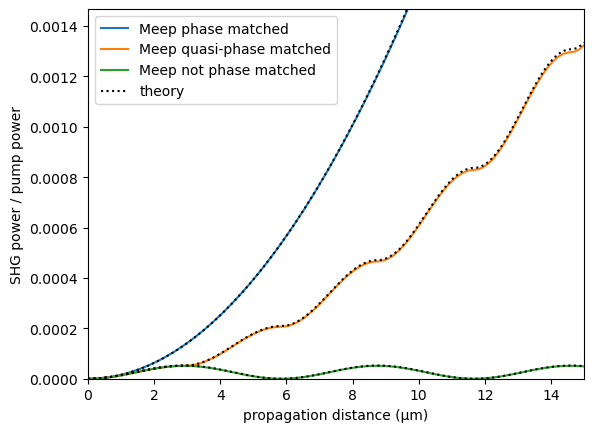

In [25]:
fig, ax = plt.subplots()

ax.plot(z, shg_powers[-1,:]/pump_power, label="Meep phase matched")
ax.plot(z, shg_power_quasi/pump_power_quasi, label="Meep quasi-phase matched")
ax.plot(z, shg_powers_disp[-1,:]/pump_power_disp, label="Meep not phase matched")

def quasi_staircase(z, delta_k):
    coherence_length = np.pi/delta_k

    if z <= coherence_length:
        y=2*np.sin(delta_k * z / 2)**2
    else:
        n = z//coherence_length
        z_current = z%coherence_length
        y = 2*n**2+2*n+1 - (1+2*n)*np.cos(delta_k*z_current)

    return y

stairs = np.array([quasi_staircase(z_i, delta_k_SI) for z_i in z_theory])
power_ratio_theory_quasi = (1/2 *  omega_pump_SI**2 / (n1*n2 * c**2 * delta_k_SI**2)
                            * (chi2_E_prod)**2 * stairs)
ax.plot(z_theory/a, power_ratio_theory_quasi, "k:", label="theory")

ax.plot(z_theory/a, power_ratio_theory_disp, "k:")
ax.plot(z_theory/a, power_ratio_theory, "k:")

ax.set_xlabel("propagation distance (µm)")
ax.set_ylabel("SHG power / pump power")
ax.set_xlim([0, z[-1]])
ax.set_ylim([0, power_ratio_theory_quasi[-1]*1.1])
ax.legend()

fig.savefig('shg_quasi.png', dpi=300, bbox_inches='tight')